Since we are dealing with an unbalanced dataset, it is recommended to use other metrics instead of accuracy.

In this case we propose to use AUC (*Area Under the Curve*) which is a measure of the classifier's ability to distinguish between classes and is used as a representation of the ROC curve. The higher the AUC, the better the performance of the model in distinguishing between the positive and negative classes.

A ROC curve (*receiver operating characteristic curve*) is a graph that shows the performance of a classification model at all classification thresholds. This curve plots two parameters: *True Positive Rate* (TPR) and *False Positive Rate* (FPR)
- TPR = TP / (TP + FN)
- FPR = FP / (FP + TN)

TPR vs. FPR are plotted at different classification thresholds. Lowering the classification threshold classifies more items as positives, which increases both false positives and true positives. The following figure shows a typical ROC curve.

In [1]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

In [3]:
import matplotlib.pylab as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
plt.style.use('seaborn-white')

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, X.shape[0]],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_X_y():
    # Fake Generate the class/group data for an example
    df_normalized = pd.read_csv('../augmented_data.csv') 
    df_normalized= df_normalized.dropna()
    print(df_normalized.shape)
    X = df_normalized.drop('estado_vital', axis=1)
    y = df_normalized['estado_vital']
    GROUPS = "edad"
    groups = pd.cut(df_normalized[GROUPS], bins=5, labels=False)
    return X, y, groups

C:\Users\Mauro\AppData\Local\Temp\ipykernel_10440\2401370119.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


(1353, 25)


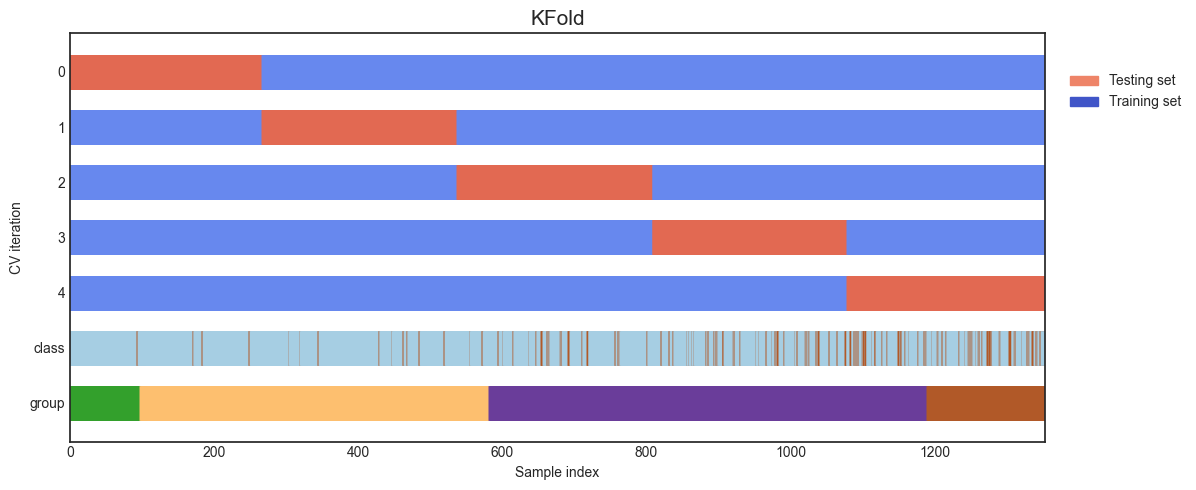

(1353, 25)


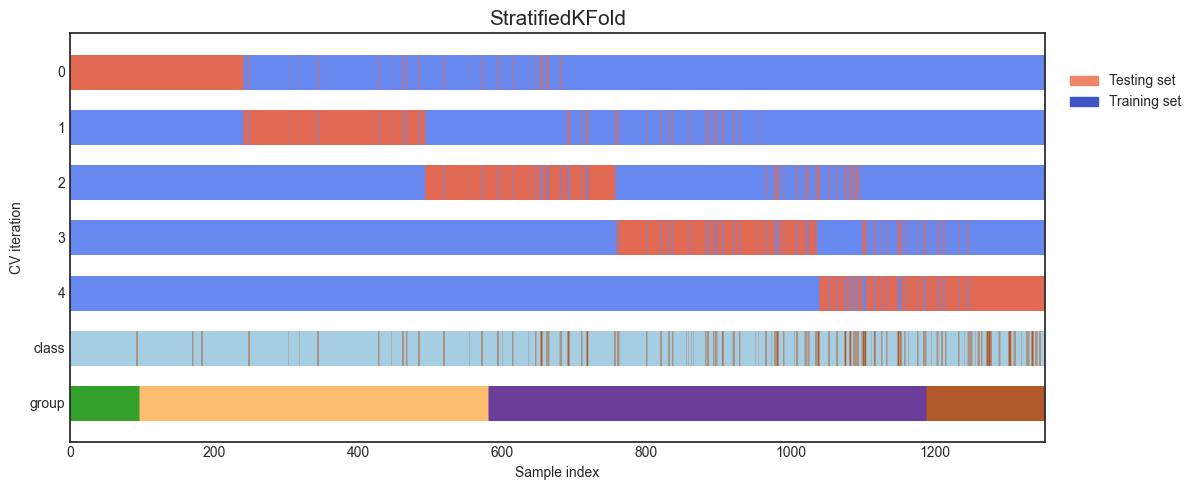

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score,precision_score

kf = KFold()
X, y, groups= get_X_y()
plot_cv(KFold, X, y,groups)
skf = StratifiedKFold()
X_, y_, groups= get_X_y()
plot_cv(StratifiedKFold, X_, y_,groups)

In [5]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)
svc=SVC(kernel='rbf',probability=True)
svc.fit(X_tr,y_tr)
y_res=svc.predict(X_val)
y_res_prob=svc.predict_proba(X_val)[:,1]
acc_score = accuracy_score(y_val,y_res)
auc_score = roc_auc_score(y_val,y_res_prob)
precision = precision_score(y_val, y_res,average='weighted')
recall = recall_score(y_val, y_res,average='weighted')
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")

print(f"Accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

Precision: 0.7778
Recall: 0.8819
Accuracy: 0.8819
AUC: 0.7407


C:\Users\Mauro\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1353, 25)


C:\Users\Mauro\AppData\Local\Temp\ipykernel_10440\2934433308.py:3: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(y_)


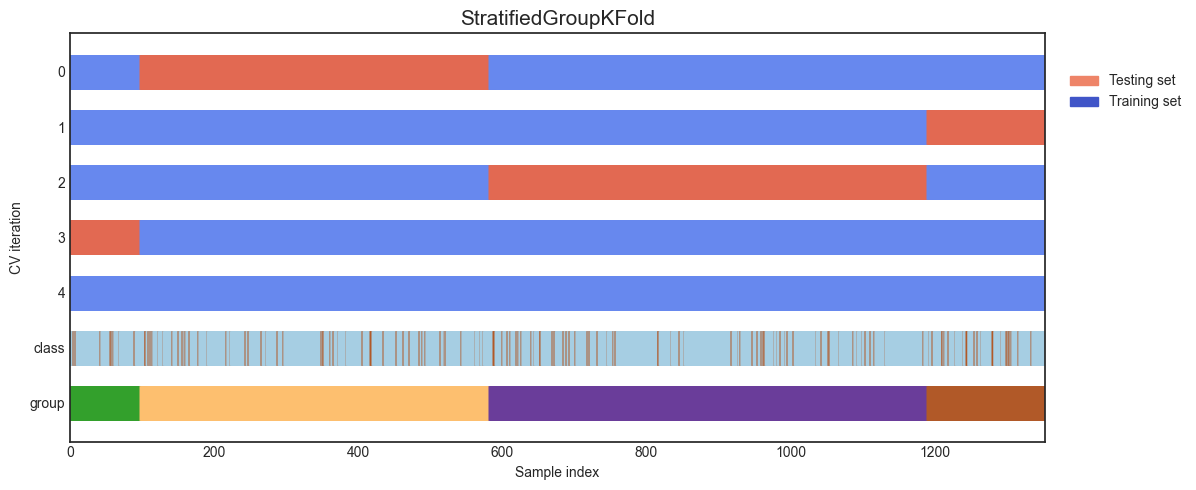

In [6]:
gskf = StratifiedGroupKFold()
X_, y_,groups = get_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups)

(1353, 25)


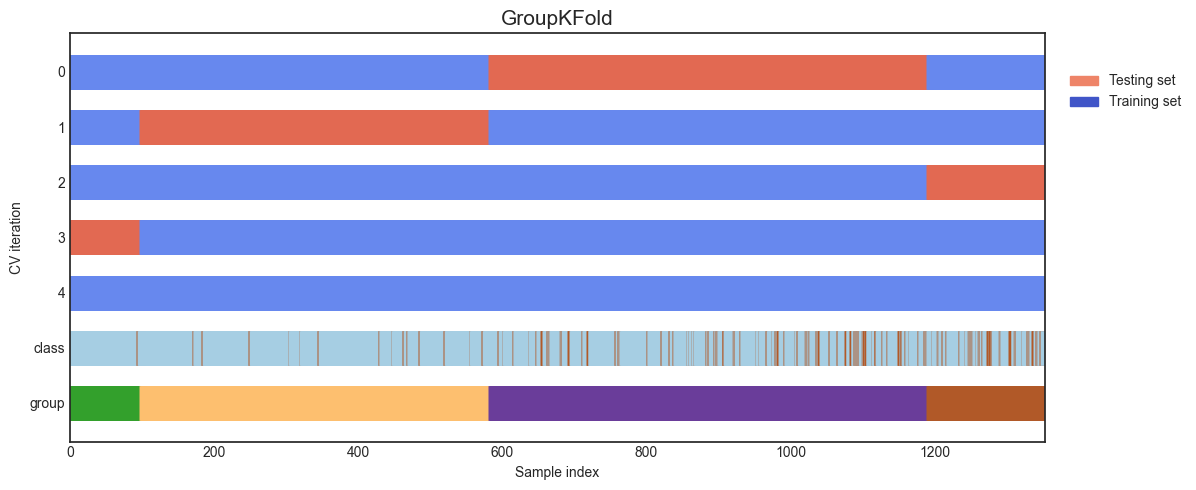

In [7]:
gkf = GroupKFold()
X_, y_, groups_ = get_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

(1353, 25)


C:\Users\Mauro\AppData\Local\Temp\ipykernel_10440\2097765019.py:3: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(y_)


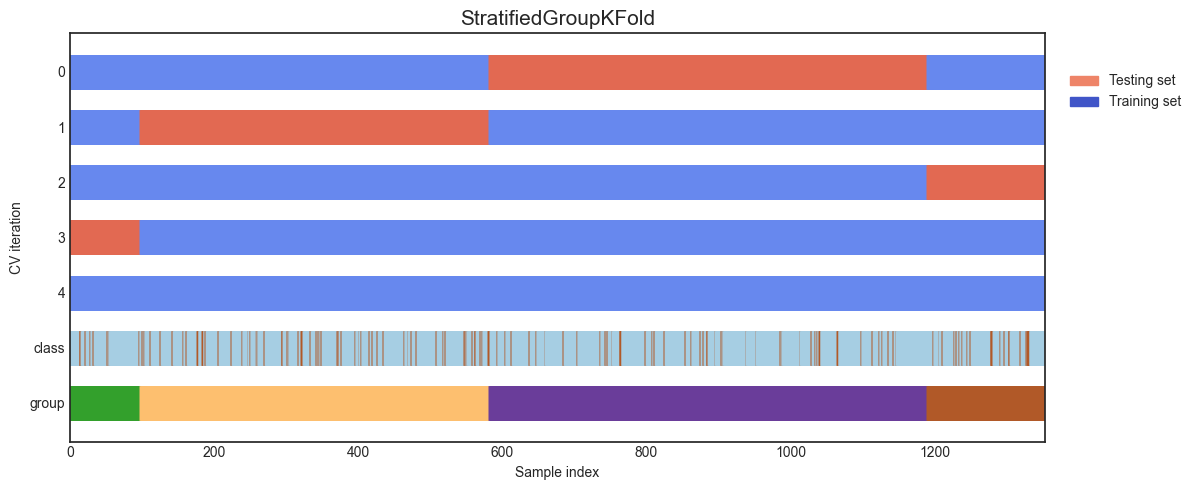

In [8]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

(1353, 25)


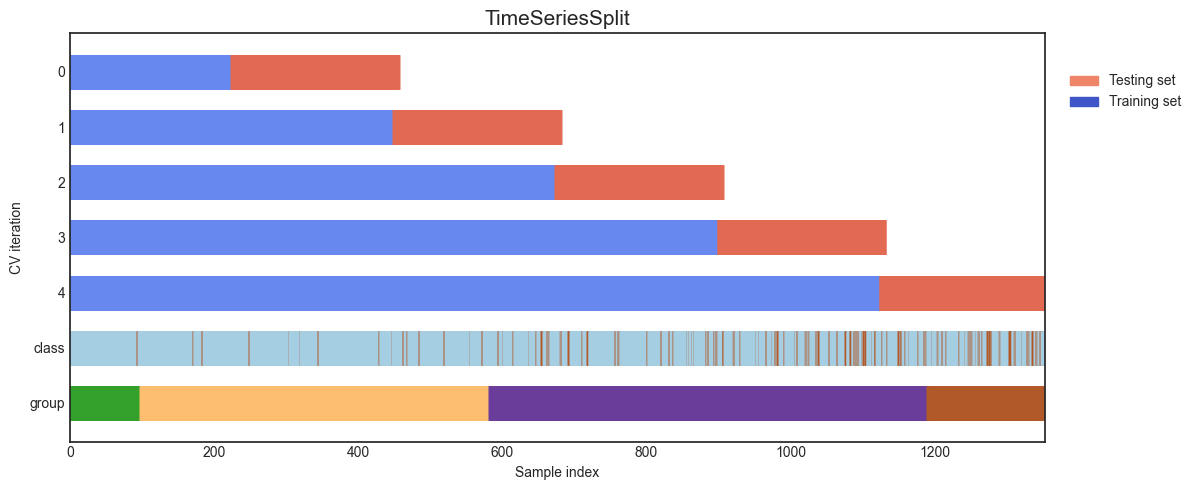

In [9]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_X_y()
plot_cv(TimeSeriesSplit, X_, y_, groups_)

In [10]:
def train_with_cv(clf, cv=StratifiedGroupKFold):
    sgk = cv(n_splits=5, shuffle=True, random_state=529)
    X, y, groups = get_X_y()

    fold = 0
    aucs = []
    precisions=[]
    recalls=[]
    for train_idx, val_idx in sgk.split(X, y, groups):
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]

        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        clf.fit(X_tr, y_tr)
        y_res=clf.predict(X_val)
        pred = clf.predict_proba(X_val)[:,1]
        
        try:
            auc_score = roc_auc_score(y_val, pred)
            precision = precision_score(y_val, y_res,average='weighted',zero_division=1)
            recall = recall_score(y_val, y_res,average='weighted')
        except ValueError:
            pass
        print(f"======= Fold {fold} ========")
        print(
            f"El AUC en el conjunto de validación es {auc_score:0.4f}"
        )
    
        print(f"Precision: {precision:0.4f}")
        print(f"Recall: {recall:0.4f}")
        fold += 1
        aucs.append(auc_score)
        precisions.append(precision)
        recalls.append(recall)
    oof_auc = np.mean(aucs)
    p_precision=np.mean(precisions)
    p_recall=np.mean(recalls)
    print(f'El resultado AUC promediado es {oof_auc:0.4f}')
    print(f'Precision promediado es {p_precision:0.4f}')
    print(f'Recall promediado es {p_recall:0.4f}')

In [11]:
train_with_cv(svc)


(1353, 25)
======= Fold 0 ========
El AUC en el conjunto de validación es 0.9583
Precision: 0.9898
Recall: 0.9897
======= Fold 1 ========
El AUC en el conjunto de validación es 0.9583
Precision: 0.9898
Recall: 0.9897
======= Fold 2 ========
El AUC en el conjunto de validación es 0.6748
Precision: 0.8248
Recall: 0.7736
======= Fold 3 ========
El AUC en el conjunto de validación es 0.6967
Precision: 0.8786
Recall: 0.8586
======= Fold 4 ========
El AUC en el conjunto de validación es 0.7635
Precision: 0.9700
Recall: 0.9690
El resultado AUC promediado es 0.8103
Precision promediado es 0.9306
Recall promediado es 0.9161


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=3, random_state=0)
clf2 = HistGradientBoostingClassifier(min_samples_leaf=10)

train_with_cv(clf1)
train_with_cv(clf2)

(1353, 25)
======= Fold 0 ========
El AUC en el conjunto de validación es 0.9583
Precision: 0.9790
Recall: 0.9485
======= Fold 1 ========
El AUC en el conjunto de validación es 0.9583
Precision: 0.9790
Recall: 0.9485
======= Fold 2 ========
El AUC en el conjunto de validación es 0.6199
Precision: 0.7020
Recall: 0.5157
======= Fold 3 ========
El AUC en el conjunto de validación es 0.7344
Precision: 0.8169
Recall: 0.8372
======= Fold 4 ========
El AUC en el conjunto de validación es 0.8849
Precision: 0.9470
Recall: 0.9504
El resultado AUC promediado es 0.8312
Precision promediado es 0.8848
Recall promediado es 0.8400
(1353, 25)
======= Fold 0 ========
El AUC en el conjunto de validación es 0.9062
Precision: 0.9898
Recall: 0.9897
======= Fold 1 ========
El AUC en el conjunto de validación es 0.9062
Precision: 0.9898
Recall: 0.9897
======= Fold 2 ========
El AUC en el conjunto de validación es 0.7879
Precision: 0.7849
Recall: 0.8050
======= Fold 3 ========
El AUC en el conjunto de validaci

# CNN

(1353, 25)
Epoch 1/13
73/73 [==============================] - 1s 3ms/step - loss: 0.5452 - accuracy: 0.8254 - val_loss: 0.3469 - val_accuracy: 0.9493
Epoch 2/13
73/73 [==============================] - 0s 1ms/step - loss: 0.3207 - accuracy: 0.8948 - val_loss: 0.2114 - val_accuracy: 0.9447
Epoch 3/13
73/73 [==============================] - 0s 1ms/step - loss: 0.2677 - accuracy: 0.8948 - val_loss: 0.1886 - val_accuracy: 0.9447
Epoch 4/13
73/73 [==============================] - 0s 1ms/step - loss: 0.2488 - accuracy: 0.8948 - val_loss: 0.1858 - val_accuracy: 0.9447
Epoch 5/13
73/73 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.8960 - val_loss: 0.1828 - val_accuracy: 0.9447
Epoch 6/13
73/73 [==============================] - 0s 1ms/step - loss: 0.2269 - accuracy: 0.8994 - val_loss: 0.1806 - val_accuracy: 0.9493
Epoch 7/13
73/73 [==============================] - 0s 1ms/step - loss: 0.2192 - accuracy: 0.9110 - val_loss: 0.1767 - val_accuracy: 0.9447
Epoch 8/1

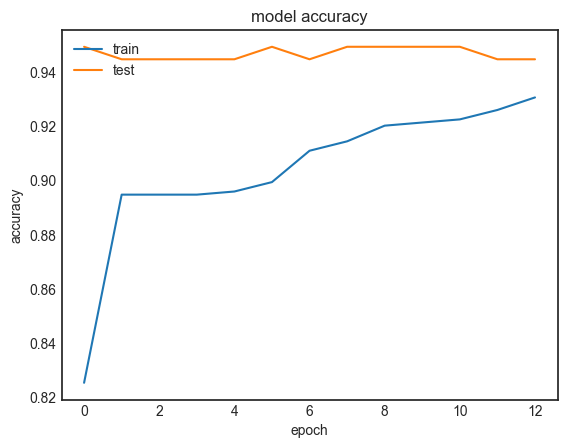

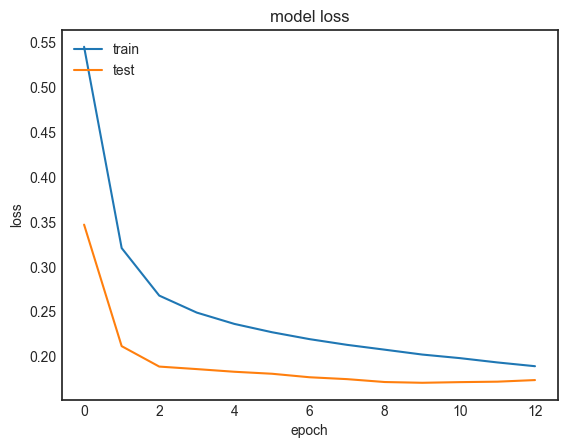

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
# dataset=pd.read_csv("data_cleaned.csv")
# Create X and y
# X = df.drop("estado_vital", axis=1)
# y= df["estado_vital"]
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_X_y()
# Split fata into train and ttest
np.random.seed(32)
#standardScaler = StandardScaler()
#columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
#dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])
# X=dataset.iloc[:,0:13]
# y=dataset.iloc[:,13:14]


# from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_,y_,test_size=0.20,random_state=10)

ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.fit_transform(X_test)


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout

#Creating a pipeline
model = Sequential()

#1st hidden layer with input layer
model.add(Dense(units=23,activation="relu",input_dim=24)) #59

#2nd hidden layer
model.add(Dense(units=12,activation="relu",))

#3rd hidden layer
model.add(Dense(units=5,activation="relu",))



#output layer
model.add(Dense(units=1,activation="sigmoid"))

# model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model_his=model.fit(X_train,y_train,validation_split=0.20, batch_size=12,epochs=13,verbose=1)


y_pred=model.predict(X_test)
y_pred = (y_pred > 0.45)
# print(y_pred)
# for i in y_pred:
#     if i:
#         print('Severe')
#     else:
#         print('Normal')
# score=accuracy_score(y_pred,y_test)
# print(score)

from sklearn.metrics import confusion_matrix,classification_report
# cm = confusion_matrix(y_test, y_pred)
# print(cm)


print(classification_report(y_test,y_pred,zero_division=0))


import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(model_his.history['accuracy'])
plt.plot(model_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(model_his.history['loss'])
plt.plot(model_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#model.save("heart.h5")